# Analysis of vacancy and foreclosures, transactions, sheriff's auctions, and armslength sales

In [1]:
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-2])
print(path)

/Volumes/Dropbox/largetransfer/luc/carter


//anaconda/envs/data_sci/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# import data

tci = pd.read_csv(path+'/data/model_data/tci_1_0.csv', parse_dates=['Date'])
tci = tci[['parcel','vacant','SPA_NAME','Date']]

dates = dict(zip(tci.parcel, tci.Date))
print(tci.shape)

(113132, 4)


//anaconda/envs/data_sci/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Foreclosures

In [4]:
# import all foreclosures

fc = pd.read_csv(path+'/data/clean_data/foreclosure_filings2.csv', parse_dates=[2])
# fc = fc.sort_values('filedate').groupby('caseno').last()
fc = fc.rename(columns={'filedate':'date'})#.reset_index()

print(fc.columns)

Index(['parcel', 'status', 'date', 'defendant', 'caseno', 'parcel_address',
       'dateid', 'case_title', 'plaintiff', 'FORE', 'LATITUDE', 'LONGITUDE',
       'zip_fore'],
      dtype='object')


## Sheriff's Auctions

Merging sheriff's auctions, transfers, and foreclosures to see order of events for each parcel.

In [2]:
# sa = pd.read_csv(path+'/data/clean_data/sheriff_auction.csv', parse_dates=[2])#, encoding="ISO-8859-1")
# sa = sa.rename(columns={'salesdt':'date'})

In [6]:
# sa = sa.loc[:,['date','parcel','sold_amt','purchaser']]
# sa['REO'] = 0
# sa['type'] = 'sa'

In [59]:
t = pd.read_csv(path+'/data/clean_data/transfers.csv', parse_dates=['mdate'], dtype=str)
t = t.rename(columns={'PROPERTY_NUMBER':'parcel','mdate':'date'})
t['type'] = 't'
t['REO'] = 0

t = t[(t.DEED_TYPE.isin(['Sheriffs Deed',
 'Sheriffs Deed Ex']))]


In [60]:
df3 = pd.read_excel(path+'/data/extra_data/STANDARDIZED.xls')
df3 = df3[['z_ngrantee','z_final']].rename(columns={'z_ngrantee':'grantee','z_final':'cat'})\
    .append(df3[['z_std','z_final']].rename(columns={'z_std':'grantee','z_final':'cat'}))

In [61]:
t3 = pd.merge(t, df3, how='left',left_on='GRANTEE1',right_on='grantee')

In [65]:
t3[(t3.cat.notnull()) & ~(t3.cat=='INDIVIDUAL')].shape

(1682, 64)

In [70]:
t3[(t3.cat.isnull())].groupby('GRANTEE1').count().sort_values(by='WHS_ID', ascending=False).index

Index(['FEDERAL NATIONAL MORTGAGE ASSOCIATION', 'FANNIE MAE',
       'FEDERAL HOME LOAN MORTGAGE CORPORATION',
       'FEDERAL NATIONAL MORTGAGE ASSOC.',
       'DEUTSCHE BANK NATIONAL TRUST COMPANY',
       'SECRETARY OF HOUSING AND URBAN DEVELOPMENT',
       'DEUTSCHE BANK NATIONAL TRUST CO., TRUSTEE',
       'DEUTSCHE BANK NATIONAL TRUST COMPANY, AS TRUSTEE', 'SECRETARY OF HUD',
       'DEUTSCHE BANK NATIONAL TRUST COMPANY AS TRUSTEE',
       ...
       'GMAC MORTGAGE , LLC', 'GILBERT, FLOYD H. JR', 'GMAC MORT CORP',
       'GMAC MORGAGE CORPORATION', 'GMAC BANK', 'GMAC  MORTGAGE CORP.',
       'GLOBAL HORSEMEN CORP', 'GLAVIN, BERARD JR. & SUSAN', 'GILMORE, ROBERT',
       'wm Specialty Mortgage llc'],
      dtype='object', name='GRANTEE1', length=6386)

In [67]:
t3[(t3.cat.isnull())].GRANTEE1

0                                          RUSSELL, ROBERT
1                                       BANK OF AMERICA NA
2                 JPMORGAN CHASE BANK NATIONAL ASSOCIATION
3                                       GMAC MORTGAGE, LLC
4                              THE BANK OF NEW YORK MELLON
5                DEUTSCHE BANK TRUST CO. AMERICAS, TRUSTEE
6                        WELLS FARGO BANK, N.A. AS TRUSTEE
7                                     US BANK N.A. TRUSTEE
8                             KEYBANK NATIONAL ASSOCIATION
9                                    US BANK NA AS TRUSTEE
10                                     GMAC MORTGAGE CORP.
12             LASALL BANK NATIONAL ASSOCIATION AS TRUSTEE
13        DEUTSCHE BANK NATIONAL TRUST COMPANY, AS TRUSTEE
14                               JPMORGAN CHASE BANK, N.A.
15                               LAKESIDE REO VENTURES LLC
17                                   BANK OF AMERICA, N.A.
18                                    BENEFICIAL OHIO IN

In [14]:
df = pd.read_csv(path+'/data/extra_data/20130901_final_dataset_restruct_1.csv')
reo = df[['z_ngrantee.1','z_final2.1']]
for num in range(2,11):
    reo = reo.append(df[['z_ngrantee.'+str(num),'z_final2.'+str(num)]]\
                     .rename(columns={'z_ngrantee.'+str(num):'z_ngrantee.1', 'z_final2.'+str(num):'z_final2.1'})\
                     ,ignore_index=True)

//anaconda/envs/data_sci/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (17,18,20,23,25,27,39,45,46,48,55,68,69,70,86,87,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
reo = reo.rename(columns={'z_ngrantee.1':'grantee','z_final2.1':'cat'})
reo = reo[reo.grantee.notnull()]
reo = reo.drop_duplicates()

In [24]:
reo.shape

(425450, 2)

In [43]:
set(reo.cat)

{' ',
 'CDC',
 'INDIVIDUAL',
 'INVESTOR COMPANY',
 'LOCAL GOVERNMENT',
 'NONPROFITS'}

In [29]:
t2 = pd.merge(t, reo, how='left',left_on='GRANTEE1',right_on='grantee')

In [15]:
# fc = fc.loc[:,['date','parcel']]
# fc['type'] = 'fc'
# fc['REO'] = 0

In [3]:
# assume real estate owned (by companies or banks) are organizations that have these series of letters in their name.
def find_REO(s):
    if isinstance(s,str):
        s = s.lower()
        if re.search("llc", s):
            return True
        if re.search("bank", s):
            return True
        if re.search("mortg", s):
            return True
        if re.search("mort.", s):
            return True
        if re.search("comp", s):
            return True
        if re.search("corp", s):
            return True
        if re.search("fannie", s):
            return True
        if re.search("housing", s):
            return True
        if re.search("sec.", s):
            return True
        if re.search("loan", s):
            return True
        if re.search("inc", s):
            return True
        if re.search("ohio", s):
            return True
        if re.search("cleveland", s):
            return True
        if re.search("estate", s):
            return True
        if re.search("organization", s):
            return True
        if re.search("develop", s):
            return True
        if re.search("ltd", s):
            return True
        if re.search("hsg", s):
            return True
        if re.search("limited", s):
            return True
        if re.search("cuyahoga", s):
            return True
        if re.search("propert", s):
            return True
        if re.search("invest", s):
            return True
        if re.search("realt", s):
            return True
        if re.search("homes", s):
            return True
        if re.search("neighbor", s):
            return True
        return False
    else:
        return False

In [8]:
#
# METHODOLOGY:

# Data included:
# Foreclosures
# Transfers: filtered for sheriff's deeds (assumed to be sheriff's sales)
# Armslength sales

# All three datasets are combined such that the dates, parcels, and types are included in the final dataset 
# Should be encoded as follows: 
# 0: parcels with no history
# 1: foreclosure
# 2: sold at sheriff's auction (to a REO entity) – considered to be vacant
# 3: sold at armslength (or sold at sheriff's auction to non-REO)

# At each date, assign each parcel a number based on the above rubric. The numbers may depend on previous date's 
# numbers and continue to increment, such that a parcel with the number 4 is in its second foreclosure process


fc = pd.read_csv(path+'/data/clean_data/foreclosure_filings2.csv', parse_dates=[2])
# fc = fc.sort_values('filedate').groupby('caseno').last()
fc = fc.rename(columns={'filedate':'date'})
fc['type'] = 'fc'
fc = fc[['date','type','parcel']]


t = pd.read_csv(path+'/data/clean_data/transfers.csv', parse_dates=['mdate'], dtype=str)
t['REO'] = t.GRANTEE1.apply(find_REO)
t = t[(t.DEED_TYPE.isin(['Sheriffs Deed',
 'Sheriffs Deed Ex']))]
t = t[['PROPERTY_NUMBER','mdate','REO']].rename(columns={'PROPERTY_NUMBER':'parcel','mdate':'date'})
t['type'] = 't'

t.loc[t.REO==False,'type'] = 'al'

al = pd.read_csv(path+'/data/clean_data/armslength.csv', dtype=str)
al = al.drop_duplicates()

# parse armslength dates
months = dict(zip(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],range(1,13)))
def parse_date(x):
    day = int(x[0:2])
    month = months[x[2:5]]
    year = int(x[5:])
    return dt.datetime(year,month,day)

al['date'] = al.mdate.apply(parse_date)
al = al.sort_values('date').rename(columns={'PROPERTY_NUMBER':'parcel'})

def parse_amount(x):
    return float(str(x)[1:].replace(',',''))

al['type'] = 'al'
al['REO'] = al.GRANTEE1.apply(find_REO)

# copies of datasets for finding the vacancy status according to the TCI survey

t_copy = pd.merge(t, tci[['parcel','Date','vacant']].set_index('parcel'), how='left',left_on='parcel',right_index=True)
t_copy = t_copy.loc[(t_copy.date < t_copy.Date)]

fc_copy = pd.merge(fc, tci[['parcel','Date','vacant']].set_index('parcel'), how='left',left_on='parcel',right_index=True)
fc_copy = fc_copy.loc[(fc_copy.date < fc_copy.Date)]

al_copy = pd.merge(al, tci[['parcel','Date','vacant']].set_index('parcel'), how='left',left_on='parcel',right_index=True)
al_copy = al_copy.loc[(al_copy.date < al_copy.Date)]

In [10]:
df = fc[['parcel','date','type']].append(t[['parcel','date','type','REO']]).append(al[['parcel','date','type']])
df2 = fc_copy[['parcel','date','type','vacant']]\
        .append(t_copy[['parcel','date','type','REO','vacant']])\
        .append(al_copy[['parcel','date','type','vacant']])
# df = df.fillna(False)
df = df.sort_values(by='date')
df2 = df2.sort_values(by='date')

In [15]:
df3 = df2.groupby('parcel').nth(-1)

In [22]:
sum(df3[df3['REO']==True].vacant),len(df3[df3['REO']==True].vacant)

(1191, 4691)

In [215]:
rng = pd.date_range('10/1/2009', periods=23, freq='3MS')
status = tci[['parcel']].copy()

for date in rng:
    tem = df[df.date < date].groupby('parcel').nth(-1)
    status = pd.merge(status, tem[['type']], how='left',left_on='parcel', right_index=True)
    status = status.rename(columns={'type':date})
    print(date, len(tem[tem.REO==True]))

2009-10-01 00:00:00 2738
2010-01-01 00:00:00 2697
2010-04-01 00:00:00 2764
2010-07-01 00:00:00 2751
2010-10-01 00:00:00 2799
2011-01-01 00:00:00 3024
2011-04-01 00:00:00 3099
2011-07-01 00:00:00 3049
2011-10-01 00:00:00 3117
2012-01-01 00:00:00 3217
2012-04-01 00:00:00 3200
2012-07-01 00:00:00 3308
2012-10-01 00:00:00 3434
2013-01-01 00:00:00 3523
2013-04-01 00:00:00 3611
2013-07-01 00:00:00 3556
2013-10-01 00:00:00 3554
2014-01-01 00:00:00 3605
2014-04-01 00:00:00 3770
2014-07-01 00:00:00 3903
2014-10-01 00:00:00 4024
2015-01-01 00:00:00 4153
2015-04-01 00:00:00 4433


In [20]:
status

NameError: name 'status' is not defined

In [216]:
status = status.set_index('parcel')
status_copy = status.copy()
status.loc[status.iloc[:,0]=='fc', status.columns[0]]  = 1
status.loc[status.iloc[:,0]=='t', status.columns[0]] = 2
status.loc[status.iloc[:,0]=='al', status.columns[0]] = 0
status.loc[status.iloc[:,0].isnull(), status.columns[0]]  = 0

In [217]:
def get_number(x):
    for col in range(1,23):
        if x.iloc[col] == s[x.iloc[col-1]%3]:
            x.iloc[col] = x.iloc[col-1]
        elif (s[x.iloc[col-1]%3] == 'fc') & (x.iloc[col] == 't'):
            x.iloc[col] =  x.iloc[col-1]+1
        elif (s[x.iloc[col-1]%3] == 'fc') & (x.iloc[col] == 'al'):
            x.iloc[col] =  x.iloc[col-1]+2
        elif (s[x.iloc[col-1]%3] == 't') & (x.iloc[col] == 'al'):
            x.iloc[col] =  x.iloc[col-1]+1
        elif (s[x.iloc[col-1]%3] == 't') & (x.iloc[col] == 'fc'):
            x.iloc[col] =  x.iloc[col-1]+2
        elif (s[x.iloc[col-1]%3] == 'al') & (x.iloc[col] == 'fc'):
            x.iloc[col] =  x.iloc[col-1]+1
        elif (s[x.iloc[col-1]%3] == 'al') & (x.iloc[col] == 't'):
            x.iloc[col] =  x.iloc[col-1]+2
        else:
            x.iloc[col] =  0
    return x

In [218]:
status2 = status.apply(get_number, axis=1).copy()

In [222]:
status2.to_csv(path+'/data/clean_data/parcel_status.csv')

In [208]:
status.columns[-1]

Timestamp('2015-04-01 00:00:00', offset='3MS')

In [112]:
dd.loc[dd.iloc[:,0]=='al', dd.columns[0]] = 1

In [160]:
dd = status.sample(10).copy()
# dd = dd.set_index('parcel')
dd.loc[dd.iloc[:,0]=='fc', dd.columns[0]]  = 1
dd.loc[dd.iloc[:,0]=='t', dd.columns[0]] = 2
dd.loc[dd.iloc[:,0]=='al', dd.columns[0]] = 0
dd.loc[dd.iloc[:,0].isnull(), dd.columns[0]]  = 0

In [97]:
s = {0:'al', 1:'fc', 2:'t'}

In [220]:
status_copy[status_copy.iloc[:,-1]=='t'].shape

(4433, 23)

In [221]:
status2[(status2.iloc[:,-1]%3)==2].shape

(4433, 23)

In [161]:
dd= dd.iloc[:,[0,1,2]]

In [162]:
dd

,2009-10-01 00:00:00,2010-01-01 00:00:00,2010-04-01 00:00:00
parcel,,,
135-10-043,0,NaN,NaN
022-13-112,0,al,al
018-23-137,0,al,al
115-27-063,0,al,al
138-06-020,0,al,al
017-29-077,1,fc,t
018-19-077,1,fc,fc
106-04-040,0,NaN,NaN
109-05-065,2,t,t


In [165]:
dd.apply(get_number, axis=1)

,2009-10-01 00:00:00,2010-01-01 00:00:00,2010-04-01 00:00:00
parcel,,,
135-10-043,0,0,0
022-13-112,0,0,0
018-23-137,0,0,0
115-27-063,0,0,0
138-06-020,0,0,0
017-29-077,1,1,2
018-19-077,1,1,1
106-04-040,0,0,0
109-05-065,2,2,2


In [193]:
status.apply(max,axis=0)

2009-10-01    2
2010-01-01    4
2010-04-01    6
2010-07-01    6
2010-10-01    6
2011-01-01    6
2011-04-01    6
2011-07-01    8
2011-10-01    8
2012-01-01    8
2012-04-01    8
2012-07-01    8
2012-10-01    9
2013-01-01    9
2013-04-01    9
2013-07-01    9
2013-10-01    9
2014-01-01    9
2014-04-01    9
2014-07-01    9
2014-10-01    9
2015-01-01    9
2015-04-01    9
dtype: int64

In [197]:
df[df.parcel=='005-24-063']

,REO,date,parcel,type
37688,NaN,2000-03-20,005-24-063,al
63619,NaN,2001-04-18,005-24-063,al
328,NaN,2005-09-26,005-24-063,al
15115,True,2005-09-26,005-24-063,t
1891,NaN,2009-11-10,005-24-063,fc
15117,False,2010-09-01,005-24-063,t
77372,NaN,2013-01-31,005-24-063,al


In [195]:
status[((status2.iloc[:,0]%3)==2) & ((status2.iloc[:,1]%3)==1)]

,2009-10-01 00:00:00,2010-01-01 00:00:00,2010-04-01 00:00:00,2010-07-01 00:00:00,2010-10-01 00:00:00,2011-01-01 00:00:00,2011-04-01 00:00:00,2011-07-01 00:00:00,2011-10-01 00:00:00,2012-01-01 00:00:00,...,2013-01-01 00:00:00,2013-04-01 00:00:00,2013-07-01 00:00:00,2013-10-01 00:00:00,2014-01-01 00:00:00,2014-04-01 00:00:00,2014-07-01 00:00:00,2014-10-01 00:00:00,2015-01-01 00:00:00,2015-04-01 00:00:00
parcel,,,,,,,,,,,,,,,,,,,,,
005-24-063,2,4,4,4,5,5,5,5,5,5,...,5,6,6,6,6,6,6,6,6,6
015-08-015,2,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
015-13-101,2,4,4,4,4,4,4,6,6,6,...,6,6,6,6,6,6,6,6,6,6
016-11-163,2,4,4,4,4,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
016-12-148,2,4,4,4,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,7
016-14-059,2,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
016-23-053,2,4,4,4,4,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
017-18-004,2,4,4,4,4,4,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
018-02-121,2,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [192]:
status[(status2.iloc[:,-1]%3)==2].shape

(5325, 23)

(5250, 23)

In [191]:
tem = df2.groupby('parcel').nth(-1)
print(date, sum(tci[tci.parcel.isin(tem[tem.REO==True].index)].vacant), len(tci[tci.parcel.isin(tem[tem.REO==True].index)].vacant))

2015-04-01 00:00:00 1191 4691


In [25]:
tem[['REO','GRANTEE1']].sample(50)

KeyError: "['GRANTEE1'] not in index"

In [42]:
sum(tci[tci.parcel.isin(tem[tem.REO==True].index)].vacant)

948

In [36]:
tem[tem.REO==True].shape

(4691, 3)

In [24]:
sum(tci[tci.parcel.isin(tem[(tem.shf==1)&(tem.REO==True)].index)].vacant)

715

In [10]:
sa['REO'] = sa.purchaser.apply(find_REO)
sa['GRANTEE1'] = sa.purchaser
t['REO'] = t.GRANTEE1.apply(find_REO)

In [11]:
# # append the datasets and eliminate dates from before they were searched, then sort by date
# df = fc.append(sa.loc[sa.sold_amt.notnull(),['date','REO','parcel','type','GRANTEE1']]).append(t[['date','parcel','type','REO','DEED_TYPE','GRANTEE1']])
# df = df.loc[df.apply(lambda x: x.date < dates[x.parcel], axis=1)]
# df = df.sort_values('date')

In [45]:
# talked to April, assume that things are in the transfers dataset
df = t[['date','parcel','type','REO','DEED_TYPE','GRANTEE1']]
df = df.loc[df.apply(lambda x: x.date < dates[x.parcel], axis=1)]
df = df.sort_values('date')

In [46]:
# get the last transaction
last = df.groupby('parcel').nth(-1)
second_last = df.groupby('parcel').nth(-2)

last.loc[(last.DEED_TYPE.isin(['Sheriffs Deed',
 'Sheriffs Deed Ex'])),'shf'] = 1

In [47]:
# merge with the vacancy status
tem = pd.merge(last, tci[['parcel','vacant']], how='left', left_index=True, right_on='parcel')

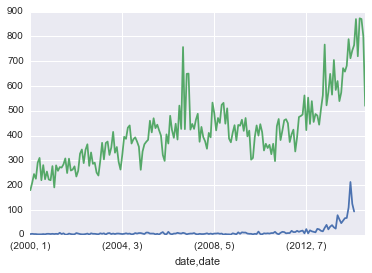

In [69]:
tem[tem.shf==1].groupby([tem.date.dt.year, tem.date.dt.month]).count()['REO'].plot(kind="line")
tem.groupby([tem.date.dt.year, tem.date.dt.month]).count()['REO'].plot(kind="line");

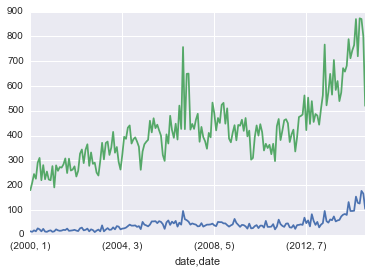

In [66]:
tem[tem.vacant==1].groupby([tem.date.dt.year, tem.date.dt.month]).count()['REO'].plot(kind="line")
tem.groupby([tem.date.dt.year, tem.date.dt.month]).count()['REO'].plot(kind="line");

In [55]:
last.median()

REO    0
shf    1
dtype: float64

In [51]:
min(t.date)

Timestamp('2000-01-03 00:00:00')

In [48]:
sum(tem[tem.shf==1].vacant), len(tem[tem.shf==1].vacant)

(678, 2062)

In [49]:
sum(tem[(tem.shf==1) & (tem.REO)].vacant), len(tem[(tem.shf==1) & (tem.REO)].vacant)

(591, 1313)

In [75]:
pitts = set(last[(last['type']=='sa')].index).intersection(set(second_last[second_last['type']=='fc'].index))

In [76]:
sum(tci[tci.parcel.isin(pitts)].vacant), len(tci[tci.parcel.isin(pitts)].vacant)

(375, 957)

In [37]:
tem.loc[(tem.DEED_TYPE.isin(['Sheriffs Deed',
 'Sheriffs Deed Ex'])),'shf'] = 1

In [31]:
tem[(tem.shf==1) | (tem['type']=='sa')].shape

(3077, 8)

In [27]:
tem[(tem.shf==1) | (tem['type']=='sa')].sample(30)

,DEED_TYPE,GRANTEE1,REO,date,type,parcel,vacant,shf
90865,Sheriffs Deed,THE HUNTINGTON NATIONAL BANK,1,2014-04-07,t,131-34-009,1,1
47216,NaN,THIRD FEDERAL SAVINGS AND LOAN ASSOCIATION OF ...,1,2015-08-17,sa,025-17-039,0,NaN
56137,Sheriffs Deed,130 PROPERTIES LLC,1,2008-11-04,t,105-25-010,1,1
24496,NaN,LUIS ALFREDO CAMACHO CAMACHO,0,2015-06-29,sa,015-04-021,0,NaN
59675,Sheriffs Deed Ex,FEDERAL NATIONAL MORTGAGE ASSOCIATION,1,2015-01-16,t,108-10-035,1,1
89125,NaN,THE BANK OF NEW YORK MELLON F K A THE BANK OF ...,1,2015-04-20,sa,130-11-063,0,NaN
23080,Sheriffs Deed,UNITED TELEPHONE CREDIT UNION INC.,1,2009-09-09,t,014-08-039,0,1
34601,Sheriffs Deed,"TRIMMER, ROBERT W.",0,2003-11-07,t,018-29-105,0,1
64724,Sheriffs Deed,"COLONIAL SAVINGS, FA",0,2013-04-01,t,110-19-086,1,1
98131,Sheriffs Deed,FEDERAL NATIONAL MORTGAGE ASSOCIATION,1,2013-03-13,t,136-04-083,1,1


In [42]:
# look at the number of vacant, 'real estate owned' parcels vs the total REO
sum(tci[(tci.parcel.isin(tem[(tem.REO==1) & ((tem.shf==1) | (tem['type']=='sa'))].parcel))].vacant), \
    len(tci[(tci.parcel.isin(tem[(tem.REO==1) & ((tem.shf==1) | (tem['type']=='sa'))].parcel))].vacant)

(904, 2151)

In [47]:
# look at the number of vacant, 'real estate owned' parcels vs the total REO
sum(tci[(tci.parcel.isin(last[(last['type']=='fc')].index))].vacant), len(tci[(tci.parcel.isin(last[(last['type']=='fc')].index))].vacant)

(2665, 11337)

In [46]:
# look at the number of vacant, 'real estate owned' parcels vs the total REO
sum(tci[(tci.parcel.isin(last[(last['type']=='fc')].index))].vacant), len(tci[(tci.parcel.isin(last[(last['type']=='fc')].index))].vacant)

(2665, 11337)

In [41]:
# look at the number of vacant, 'real estate owned' parcels vs the total REO
sum(tci[(tci.parcel.isin(last[(last.REO==1)].index))].vacant), len(tci[(tci.parcel.isin(last[(last.REO==1)].index))].vacant)

(2037, 9336)

Compare with Pittsburgh's measure, which is a house that has been foreclosed and not yet sold in sheriff's auction or transferred.

In [226]:
sub = set(last[last['type'] == 'fc'].index)
sum(tci[tci.parcel.isin(sub)].vacant), len(tci[tci.parcel.isin(sub)].vacant)
# second_last = df.groupby('parcel').nth(-2)
# sub2 = set(second_last[second_last['type']=='fc'].index)

(2665, 11337)

So only 2665 out of 11337 parcels that meet this criteria are actually vacant, which is not a very good percentage.

## Postal vacancies

In [227]:
pv = pd.read_csv(path+'/data/clean_data/postal_vacancy.csv', parse_dates=3, index_col=0)
pv.date = pv.date.apply(lambda x: dt.datetime(int(x[0:4]),int(x[5:7]),int(x[8:10])))
pv = pv.sort_values('date',ascending=False)
pv = pv.loc[pv.apply(lambda x: x.date < dates[x.PARCEL], axis=1)]

In [228]:
# count the number of consecutive times a parcel is postal vacant, working backwards
def fun(x):
    total = 0
    recent = pv_dates[pv_dates<dates[x.parcel]]

    for i,j in enumerate(x[recent]):
        if x[recent][-i-1] == 'Y':
            total += 1
        else:
            return total
    return total

pv_dates = pv.groupby('date').last().index
pv2 = pv.pivot(index='PARCEL',columns='date').fillna('N').reset_index()
pv2.columns = pv2.columns.droplevel()
pv2.columns.values[0] = 'parcel'
pv2['pv_count'] = pv2.apply(fun, axis=1)
pv2 = pv2.set_index('parcel')

Compare the number of postal vacant homes (at least 1 term in a row) to the actually vacant homes.

In [70]:
sum(tci.vacant), len(tci.vacant)

(10038, 113132)

In [230]:
sum(tci[tci.parcel.isin(pv2[pv2.pv_count>0].index)].vacant),len(tci[tci.parcel.isin(pv2[pv2.pv_count>0].index)].vacant)

(4426, 8904)

About half of the postal vacant homes are actually vacant right now. That's a lot better than the other measures, but still far away from being as accurate as we'd like.